#  Описание проекта
<a id="defenition"></a>
Проверка гипотез для увеличения выручки инет магазина. Анализ гипотез с использованием фреймворков ICE и RICE. Анализ оезультатов A/B теста. 


1. [Описание проекта](#defenition)


2. [Открытие исходных данных](#start)


3. [Изучение данных](#preprocessing)  


4. [Изучение гипотез](#hypotesys)


5. [Анализ А/В теста](#analysis)
    * 5.1 [График кумулятивной выручки по группам](#step1)
    * 5.2 [График кумулятивного среднего чека по группам](#step2)
    * 5.3 [График относительного изменения кумулятивного среднего чека группы B к группе A](#step3)
    * 5.4 [График кумулятивной конверсии по группам](#step4)
    * 5.5 [График относительного изменения кумулятивной конверсии группы B к группе A](#step5)
    * 5.6 [График количества заказов по пользователям](#step6)
    * 5.7 [Расчет 95-го и 99-го перцентилей количества заказов на пользователя](#step7)
    * 5.8 [График стоимостей заказов](#step8)
    * 5.9 [Расчет 95-го и 99-го перцентилей стоимости заказов](#step9)
    * 5.10 [Расчет статистической значимости различий в конверсии между группами по «сырым» данным](#step10)
    * 5.11 [Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#step11)
    * 5.12 [Расчет статистической значимости различий в конверсии между группами по «очищенным» данным](#step12)
    * 5.13 [Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#step13)
    * 5.14 [Графики конверсии, среднего чека и кумулятивной выручки по "чистым" данным](#step14)


5. [Заключение. Общий вывод](#resume)

*Гипотезы*

* __``Hypothesis``__ — *краткое описание гипотезы;*
* __``Reach``__ — *охват пользователей по 10-балльной шкале;*
* __``Impact``__ — *влияние на пользователей по 10-балльной шкале;*
* __``Confidence``__ — *уверенность в гипотезе по 10-балльной шкале;*
* __``Efforts``__ — *затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.*

*Заказы*

* __``transactionId``__ — *идентификатор заказа;*
* __``visitorId``__ — *идентификатор пользователя, совершившего заказ;*
* __``date``__ — *дата, когда был совершён заказ;*
* __``revenue``__ — *выручка заказа;*
* __``group``__ — *группа A/B-теста, в которую попал заказ.*

*Пользователи*

* __``date``__ — *дата;*
* __``group``__ — *группа A/B-теста;*
* __``visitors``__ — *количество пользователей в указанную дату в указанной группе A/B-теста*

# Открытие исходных даных
<a id="start"></a>

In [1]:
#pip install pandas_profiling

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import scipy.stats as st
from scipy.stats import mannwhitneyu

In [3]:
# открываем датасеты
try:
    hypothesis = pd.read_csv('d:/Home/datasets/hypothesis.csv')
    orders = pd.read_csv('d:/Home/datasets/orders.csv')
    visitors = pd.read_csv('d:/Home/datasets/visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

In [4]:
# настройки
pd.set_option('max_rows', 8)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
#pd.reset_option
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["figure.dpi"] = 90
alpha = 0.05

<a class="anchor" id="11-bullet">

# Изучение, предобработка
<a id="preprocessing"></a>

In [5]:
# общий вид
orders.sample(3)

,transactionId,visitorId,date,revenue,group
41,2594268419,237748145,2019-08-15,1090,A
433,3312757456,994339272,2019-08-24,5770,A
504,2541233311,4027578749,2019-08-25,2590,A


In [6]:
# типы
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
# Имеются ли пропуски
orders.isnull().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [8]:
# Имеются ли дубликаты
orders.duplicated().sum()

0

In [9]:
# статистика
orders.describe()

,transactionId,visitorId,revenue
count,1197.00,1197.00,1197.00
mean,2155621385.53,2165960143.10,8348.01
std,1229084904.76,1236014192.15,39191.13
min,1062393.00,5114589.00,50.00
25%,1166775572.00,1111826046.00,1220.00
50%,2145193898.00,2217984702.00,2978.00
75%,3237740112.00,3177606451.00,8290.00
max,4293855558.00,4283872382.00,1294500.00


profile = ProfileReport(orders, title='Pandas Profiling Report')
profile.to_widgets()

Дубликатов, пропуков нет. Имеются очень сильные  забросы. 75% покупателей совершают покупку на суму не более 9 000. ТОлько 5% покупают на сумму более 28 000

profile = ProfileReport(visitors, title='Pandas Profiling Report')
profile.to_widgets()

In [10]:
# общий вид
visitors.sample(3)

,date,group,visitors
28,2019-08-29,A,577
37,2019-08-07,B,709
38,2019-08-08,B,654


In [11]:
# типы
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
# Имеются ли пропуски
visitors.isnull().sum()

date        0
group       0
visitors    0
dtype: int64

In [13]:
# Имеются ли дубликаты
visitors.duplicated().sum()


0

In [14]:
visitors[visitors['group'] == "A"].shape[0]

31

In [15]:
visitors[visitors['group'] == "B"].shape[0]

31

Дубликатов, забросов, пропусков нет. В каждой группе одинаковое количество уникальных пользователей.

##### Проверка данных на нормальность

In [16]:
results = st.shapiro(orders[orders['group'] == "A"]['revenue'].tolist())
p_value = results[1] 

if (p_value < alpha):
    print("Распределение группы А не нормально. p-значение: ", p_value)
else:
    print("Распределение нормальное. p-значение: ", p_value) 

Распределение группы А не нормально. p-значение:  1.739703399801917e-34


In [17]:
results = st.shapiro(orders[orders['group'] == "B"]['revenue'].tolist())
p_value = results[1] 

if (p_value < alpha):
    print("Распределение группы B не нормально. p-значение: ", p_value)
else:
    print("Распределение нормальное. p-значение: ", p_value) 

Распределение группы B не нормально. p-значение:  0.0



Hулевая гипотеза - группы различны. Альтернативная - различий нет


In [18]:
# Hулевая гипотеза - группы различны. 
sample_A = orders[orders['group'] == "A"]['revenue'].values.tolist()
sample_B = orders[orders['group'] == "B"]['revenue'].values.tolist()
#results = st.mannwhitneyu(sample_A, sample_B)

stat, p  = mannwhitneyu(sample_A, sample_B,  alternative='two-sided')                                                  
                                                                                                             

if (p < alpha):
    print("Отвергаем нулевую гипотезу: разница групп статистически значима. 'p-значение: ", p)
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии групп А и В сделать нельзя. 'p-значение: ", p) 

Не получилось отвергнуть нулевую гипотезу, вывод о различии групп А и В сделать нельзя. 'p-значение:  0.7292909855432458


Выборки групп А и В по стоимости покупок на сырых данных не имеют нормального распределения, но статистически группы не имеют различия

# Изучение гипотез
<a id="hypotesys"></a>

In [19]:
hypothesis[:3]

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3




Расчет по формулам

<br>

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$
</div>


In [20]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['ICE']

In [21]:
numeric_columns = ['ICE','RICE']
string_columns = ['Hypothesis']

In [22]:
#hypothesis.sort_values(by='ICE', ascending=False) 

Сортировка по убыванию ICE

In [23]:
# Подсветим минимум, максимум
(hypothesis \
     .sort_values(by='ICE', ascending=False) \
     .style\
     .highlight_max(color='yellowgreen', subset=numeric_columns)\
     .highlight_min(color='coral', subset=numeric_columns) \
     .set_properties(**{'text-align': 'left'}, subset='Hypothesis'))


,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000


Сортировка по убыванию RICE


In [24]:
(hypothesis \
     .sort_values(by='RICE', ascending=False) \
     .style\
     .highlight_max(color='yellowgreen', subset=numeric_columns)\
     .highlight_min(color='coral', subset=numeric_columns) \
     .set_properties(**{'text-align': 'left'}, subset='Hypothesis'))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000


Две из трех первых гипотез по критерию ICE, остались также в первой тройке по RICE. Лучшая гипотеза по критерю ICE, по RICE оказалась в середине приоритетов. Полагаясь на оценку по ICE предпочтительнее гипотеза о запуске акционных скидок в день рождения. Наиболее лучшая согласно критерию  RICE гипотеза о добавлении формы подписки на все основные страницы для сбора базы клиентов для email-рассылок. Гипотеза о добавлении формы подписки охватывает всех потенциальных пользователей и потому имеет больше эффект. Тот факт, что при приоритизации по RICE гипотеза об акции в день рождения отодвинулась в середину списка объясняется высокими затратами на реализацию и маленьким охватом пользвателей, которых коснутся изменения. 


Возможно стоит рассмотреть RICE и гипотезу о форме подписки: охват больше, значит скорее всего конверсия будет выше, а результат повышения конверсии - повышение прибыли. Бонусом возможно получится запустить акционную рассылку в  день рождения сминимальными затратами. 


# Анализ A/B-теста
<a id="analysis"></a>

## График кумулятивной выручки по группам
<a id="step1"></a>

In [25]:
# Преобразуем формат даты
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# Выделим  дату и принадлежность к группе
datesGroups = orders[['date','group']].drop_duplicates()

In [26]:
# агрегированные данные
ordersAggregated = datesGroups.apply \
    (lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])] \
        .agg( \
            {'date' : 'max' \
            ,'group' : 'max' \
            ,'transactionId' : pd.Series.nunique \
            ,'visitorId' : pd.Series.nunique \
            ,'revenue' : 'sum'} \
            ) \
        , axis=1 \
    ).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply \
    (lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
        .agg({ \
            'date' : 'max' \
            ,'group' : 'max' \
            ,'visitors' : 'sum'} \
            ) \
        ,axis=1 \
    ).sort_values(by=['date','group'])


In [27]:
# Выделяем кумулятивные данные
cumulativeData = ordersAggregated.merge( \
                                        visitorsAggregated \
                                        ,left_on=['date', 'group'] \
                                        ,right_on=['date', 'group'] \
                                       )
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

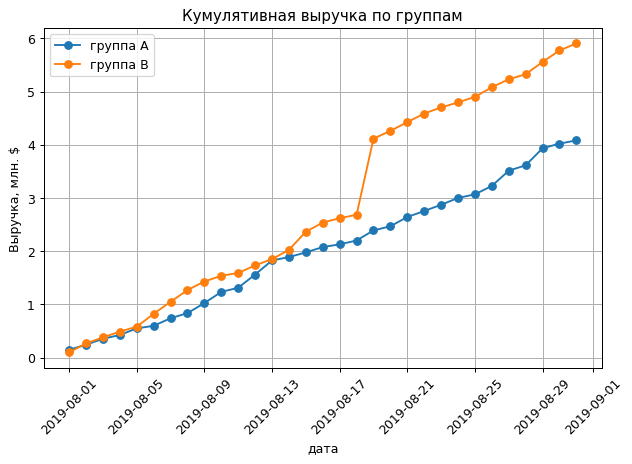

In [28]:
# Строим графики

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']*1.e-6, 'o-',label='группа A');
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']*1.e-6, 'o-',label='группа B');
plt.legend();

plt.title('Кумулятивная выручка по группам');
plt.xlabel('дата');
plt.ylabel('Выручка, млн. $');
plt.xticks(rotation=45);
plt.grid(True);
#plt.xlim("2019-07-31", "2019-09-02")

Группа В выглядит лучше. Не совсем понятен скачок 18 августа 2019. Возможно к этому привели новые условия продаж, потому что тенденция в разнице продаж между группами сохраняется после скачка.

## График кумулятивного среднего чека по группам
<a id="step2"></a>

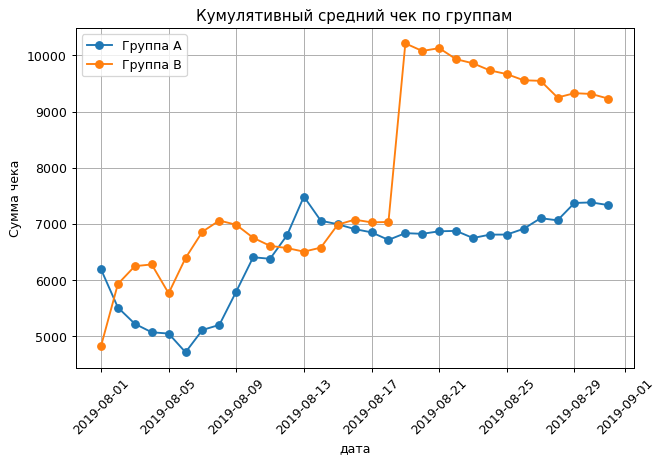

In [29]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 'o-',label='Группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 'o-',label='Группа B')
plt.legend(loc='upper left');

plt.title('Кумулятивный средний чек по группам');
plt.xlabel('дата');
plt.ylabel('Сумма чека');
plt.xticks(rotation=45);
plt.grid(True);

В группе А средний чек имеет практически не меняется после 17 августа 2019, колеблется возле значения 7 000, возможно слабая иенденция к росту. Средний чек группы В имеет скачок, одновременно с ростом накопительной выручки. В отличие от выручки, сумма среднего чека по группе В падает после скачка. То есть в группе В покупок стало больше, но сумма чека уменьшилась.

## График относительного изменения кумулятивного среднего чека группы B к группе A
<a id="step3"></a>


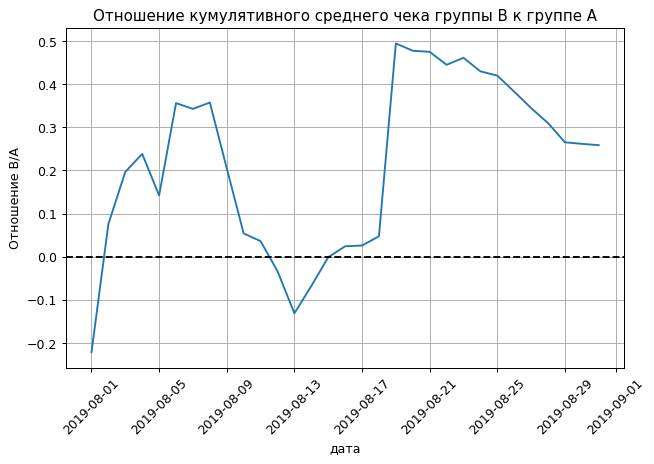

In [30]:
# соединиение таблиц по дате кумулятивной выручки групп 
mergedCumulativeRevenue = cumulativeRevenueA.merge( \
                                    cumulativeRevenueB \
                                    ,left_on='date' \
                                    ,right_on='date' \
                                    ,how='left' \
                                    ,suffixes=['A', 'B'])

# отношение средних чеков
plt.plot( \
         mergedCumulativeRevenue['date'] \
         ,(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) \
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1);

# ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Отношение кумулятивного среднего чека группы B к группе A');
plt.xlabel('дата');
plt.ylabel('Отношение B/A');
plt.xticks(rotation=45);
plt.grid(True);


Нельзя сказать, что кумулятивный относитеьный средний чек группы В по отношению к группе А, имеет четкую тенденцию. На графике два периода колебаний, кроме этого в некоторые моменты времени группа В имеет проигрыш перед группой А. В среднем группа В выглядит лучше.

## График кумулятивной конверсии по группам
<a id="step4"></a>

In [31]:
# конверсия групп
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

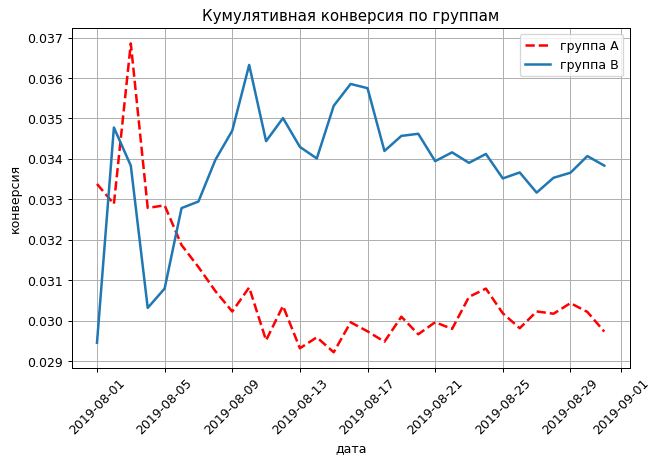

In [32]:
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'],'r--', linewidth = 2, label='группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], linewidth = 2,label='группа B')
plt.legend()
#plt.axis(["2019-03-10", '2019-04-23', 0, 0.05])
plt.title('Кумулятивная конверсия по группам');
plt.xlabel('дата');
plt.ylabel('конверсия');
plt.xticks(rotation=45);
plt.grid(True);


В первый период времени конверсия очень подвержена скачкам в обеих группах. Примерно после 13.08.2019  намечается установившиеся колебания конверсии у групы А возле значения 3%. В тоже время у группы В намечается тенденция  к снижению конверсии, хотя значение 3.4% и выше чем в группе А около 3%. Но в обеих группах график показывает  колебания конверсии с амплитудой колебаний около 1.5%..2%

## График относительного изменения кумулятивной конверсии группы B к группе A
<a id="step5"></a>

In [33]:

mergedCumulativeConversions = cumulativeDataA[['date','conversion']] \
                            .merge(cumulativeDataB[['date','conversion']] \
                                   ,left_on='date' \
                                   ,right_on='date' \
                                   ,how='left' \
                                   ,suffixes=['A', 'B'] \
                                  )

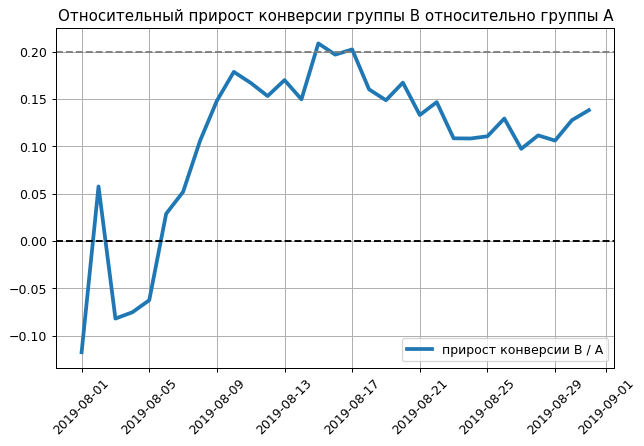

In [34]:

plt.plot(mergedCumulativeConversions['date'] \
             ,mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1 \
             ,label="прирост конверсии B / A" \
             ,linewidth = 3 \
        )
plt.legend();

plt.title("Относительный прирост конверсии группы B относительно группы A");
plt.axhline(y=0, color='black', linestyle='--');
plt.axhline(y=0.2, color='grey', linestyle='--');
#plt.axis(["2019-03-10", '2019-04-23', -0.5, 0.5]) 
plt.xticks(rotation=45);
plt.grid(True);

График относительной конверии группы А к группе В носит колебательный характер, но явно заметно, что после после подъема в первой трети временного интервала, конверсия группы В выше конверсии группы А в среднем на 13%.

## Точечный график количества заказов по пользователям
<a id="step6"></a>

#orders['revenue'].value_counts(normalize = True)

In [35]:
# удаление дубликатов, группировка по пользователямб подсчтет заказов каждого пользователя
ordersByUsers = orders \
                    .drop(['group', 'revenue', 'date'], axis=1) \
                    .groupby('visitorId', as_index=False) \
                    .agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['visitorId','orders']

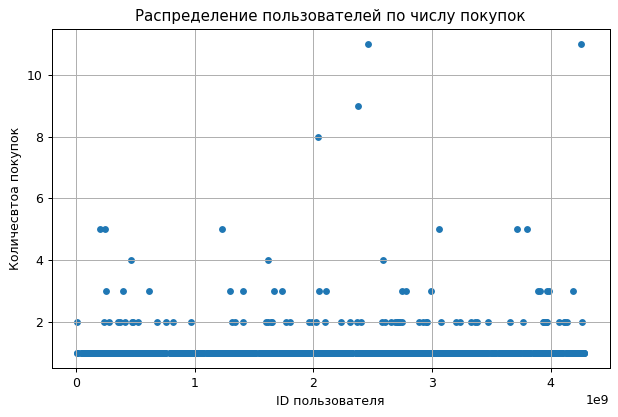

In [36]:
ordersByUsers.plot(x='visitorId', y='orders', kind='scatter');
#plt.plot(ordersByUsers['visitorId'], ordersByUsers['orders'], kind='scatter');

plt.title("Распределение пользователей по числу покупок");
#plt.legend(bbox_to_anchor=(0.5, 0.5))
plt.xlabel('ID пользователя');
plt.ylabel('Количесвтоа покупок')
#plt.axis(["2019-03-10", '2019-04-23', -0.5, 0.5]) 
plt.xticks(rotation=0);
plt.grid(True);


Основной объем покупателей совершает 1 покупку, 2 и 3 поекпки делают значмительно реже. Имеются покупатели , совершившие 4,5 и более покупок

распределение среднего чека по пользователям


In [37]:
print("p90 = {0:.2f}".format(np.percentile(orders['revenue'], 90)))
print("p95 = {0:.2f}".format(np.percentile(orders['revenue'], 95)))
print("p99 = {0:.2f}".format(np.percentile(orders['revenue'], 99)))

p90 = 18168.00
p95 = 28000.00
p99 = 58233.20


In [38]:
checkByUsers = orders.query('revenue < 1.e5') \
                    .drop(['group', 'date'], axis=1) \
                    .groupby('visitorId', as_index=False) \
                    .agg({'revenue' : 'mean'})
checkByUsers.columns = ['visitorId','check']

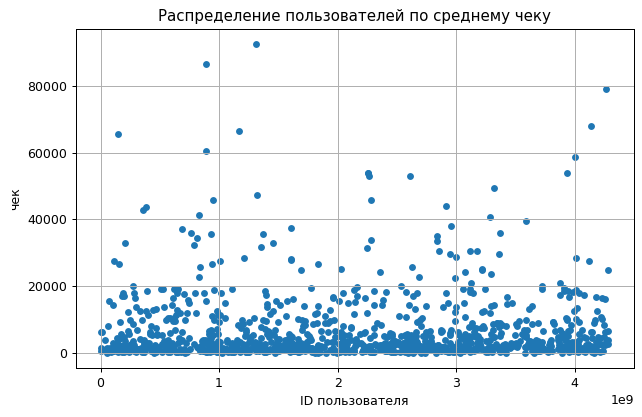

In [39]:

checkByUsers.plot(x='visitorId', y='check', kind='scatter');
#plt.plot(ordersByUsers['visitorId'], ordersByUsers['orders'], kind='scatter');

plt.title("Распределение пользователей по среднему чеку");
plt.xlabel('ID пользователя');
plt.ylabel('чек')
#plt.axis(["2019-03-10", '2019-04-23', -0.5, 0.5]) 
plt.xticks(rotation=0);
plt.grid(True);


Большое желание оставить 10 000, но тогда отбрасываетя уже 25% покупателей, что много. Да и 28 000 это 95 процентиль, что приемлемо


## Расчет 95-го и 99-го перцентилей количества заказов на пользователя
<a id="step7"></a>

In [40]:
#p95 = np.percentile(ordersByUsers['orders'], 95) 
#p99 = np.percentile(ordersByUsers['orders'], 99) 
print("p95 = {0:.2f}   p99 = {0:.2f}".format(np.percentile(ordersByUsers['orders'], 95)))
print("p99 = {0:.2f}   p99 = {0:.2f}".format(np.percentile(ordersByUsers['orders'], 99)))

p95 = 2.00   p99 = 2.00
p99 = 4.00   p99 = 4.00


Расчет совпадает c графиком. Доля пользователей совершивших более 4 покупок не привышает 1%, а доля пользователей совершивших более 2 покупок составляет не более 5%  от общего числа покупателей.

## Расчет статистической значимости различий в конверсии между группами по «сырым» данным
<a id="step7"></a>


In [41]:
# выделение группы, 
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
# число пользователей по дням суммарно до выбранной даты
visitorsACummulative = visitorsADaily.apply( \
        lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [42]:
visitorsADaily[:2]

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619


In [43]:
visitorsACummulative[:3]

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845


In [44]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']] \
    .groupby('date', as_index=False) \
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']] \
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersACummulative[:2]

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401


In [45]:
# Повторми для группы В
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply( \
        lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [46]:
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply( \
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']] \
        .agg({ \
                'date' : 'max' \
                ,'ordersPerDateB' : 'sum' \
                ,'revenuePerDateB' : 'sum'} \
            ),axis=1 \
        ).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [47]:
# сведем дневные накопительные расходы покупок, суммы чеков, числа покупателей в одну таблицу

data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
        .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
        .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
        .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
        .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
        .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
        .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

# покупатели и количество покупок для каждого
ordersByUsersA = orders[orders['group']=='A'] \
        .groupby('visitorId', as_index=False) \
        .agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'] \
        .groupby('visitorId', as_index=False) \
        .agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

ordersByUsersA.sample(2)

,visitorId,orders
15,182753106,1
440,3719891787,1


In [48]:
# пользователи делавашие заказы по группам А,В
sampleA = pd.concat([ordersByUsersA['orders'], \
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'] \
        ,pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 


In [49]:

ordersByUsersA = orders[orders['group']=='A'] \
        .groupby('visitorId', as_index=False) \
        .agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'] \
        .groupby('visitorId', as_index=False) \
        .agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'] \
                     ,pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders') \
                    ],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'] \
                     ,pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders') \
                    ],axis=0)

ordersByUsersA.sample(2)

,userId,orders
263,2303470071,1
444,3766097110,1


гипотеза H0: статистически значимых различий в конверсии между группами нет

In [50]:
"p-value: {0:.5f}".format(st.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1])

'p-value: 0.01679'

Значение p-value = 0.01679 меньше 0.05. Гипотеза о том, что в сырых данных различий в конверсии между группами нет, не подтвердилась и вынуждены от нее отказаться в пользу альтернативной гипотезы, что конверсии в группе А и В различаются. 




относительное изменение величины конверсии B/A

In [51]:
"{0:.2%}".format(sampleB.mean()/sampleA.mean()-1)

'13.81%'

относительное изменение величины конверсии B/A около 14%. Изменения существенные, учитывая, что статисттически это не случайно, очень неплохой прирост конверсии

## Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным
<a id="step9"></a>

In [52]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("относительный средний чек: {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.365
относительный средний чек: 0.259


значение статистической значимости p-value = 0.365, что больше чем 0.05. Хотя средние чеки по группам различны, предположение о том, что средние чеки по группам отличаются статистически, оказалось неверным


## Расчет статистической значимости различий в конверсии между группами по «очищенным» данным
<a id="step12"></a>   

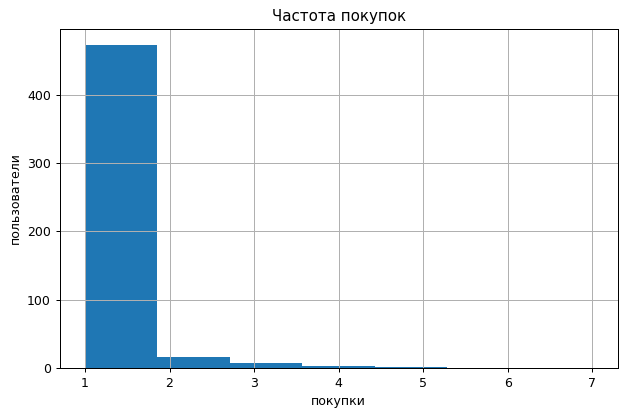

In [53]:
plt.hist(ordersByUsersA['orders'], bins=7);
plt.title("Частота покупок");
plt.xlabel('покупки');
plt.ylabel('пользователи')
plt.xticks(rotation=0);
plt.grid(True);

In [54]:
"p95 = {0:.2f}   p99 = {0:.2f}".format(np.percentile(orders['revenue'], 95),np.percentile(orders['revenue'], 99))

'p95 = 28000.00   p99 = 28000.00'

Оставим пользователей совершивших 3 и менее покупки с суммой покупки не более 18 000

In [55]:
#  считаем номальным 3 и менее покупки одним пользователем и сумма до 28 000
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'] \
                                 ,ordersByUsersB[ordersByUsersB['orders'] > 3]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

print("Число отброшенных пользователей: ", abnormalUsers.shape[0])

Число отброшенных пользователей:  63


In [56]:
#len(orders.query('group == "B"')['visitorId'].unique())
#len(orders['visitorId'].unique())                                         

Будем считать, что нормальная покупка не превышает суммы 28 000, а число нормальных покупок каждого пользователя в среднем не превашает 3

In [57]:
usersWithManyOrders = pd.concat \
    ( \
     [ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'] \
      , ordersByUsersB[ordersByUsersB['orders'] > 3]['userId']] \
      ,axis = 0 \
    )
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0) \
        .drop_duplicates() \
        .sort_values()

sampleAFiltered = pd.concat([ \
                             ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'] \
                             ,pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders') \
                            ],axis=0)

sampleBFiltered = pd.concat([ \
                             ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'] \
                             ,pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders') \
                            ],axis=0) 


In [58]:
# p-value конверсии
"p-value: {0:.5f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])

'p-value: 0.00897'

Конверсия по отфильтрованным данным отличается несильно от конверсии по не фильтрованным данным. Гипотеза, что в отфильтрованных данных статистически значимых различий в конверсии между группами нет, неверна. 


In [59]:
# Относительная конверсия группы В по отношению к группе А
#"{0:.2%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)
print(f"Относительная конверсия группы В по отношению к группе А {(sampleBFiltered.mean()/sampleAFiltered.mean()-1)}")

Относительная конверсия группы В по отношению к группе А 0.14846453749198907


## Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным
<a id="step13"></a>

In [60]:
print("уровень статичстической значимости: {0:.3f}".format(st.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("относителный средний чек между группами: {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 


уровень статичстической значимости: 0.488
относителный средний чек между группами: -0.017


Величина p-value после исключения выбросов выросла на 20% и также превышает допустимые 0.05. Вероятность 50% получить одинаковые результаты в группах, что говорит об отсутствии различия групп по среднему чеку. Относительный среднийй чек незначительно уменьшился,  изменениями в третьем знаке можно принебречь 

## Графики конверсии, среднего чека, кумулятивной выручки по «очищенным» данным
<a id="step14"></a>

##### Общие вспомогательные вычисления

In [61]:
# уберем  "ненормальных" пользователей с большим чеком и частыми покупками
ordersClear = orders.query('visitorId not in @abnormalUsers')


ordersAggregated = datesGroups.apply \
    (lambda x: ordersClear[np.logical_and(ordersClear['date'] <= x['date'], ordersClear['group'] == x['group'])] \
        .agg( \
            {'date' : 'max' \
            ,'group' : 'max' \
            ,'transactionId' : pd.Series.nunique \
            ,'visitorId' : pd.Series.nunique \
            ,'revenue' : 'sum'} \
            ) \
        , axis=1 \
    ).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply \
    (lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
        .agg({ \
            'date' : 'max' \
            ,'group' : 'max' \
            ,'visitors' : 'sum'} \
            ) \
        ,axis=1 \
    ).sort_values(by=['date','group'])


# Выделяем кумулятивные данные
cumulativeData = ordersAggregated.merge( \
                                        visitorsAggregated \
                                        ,left_on=['date', 'group'] \
                                        ,right_on=['date', 'group'] \
                                       )
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

#### конверсия

In [62]:
# конверсия групп
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

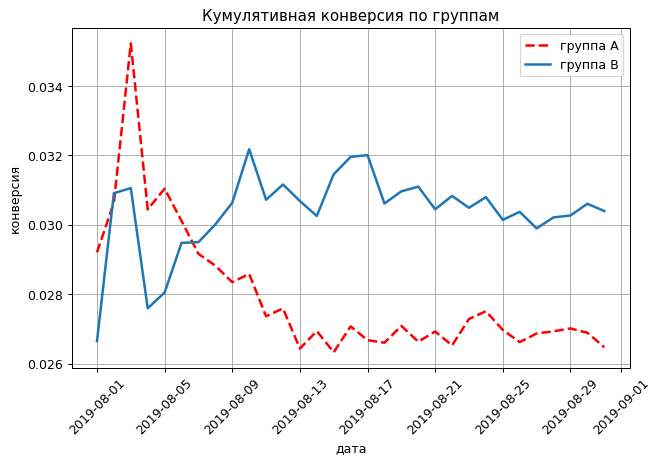

In [63]:
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'],'r--', linewidth = 2, label='группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], linewidth = 2,label='группа B')
plt.legend()
plt.title('Кумулятивная конверсия по группам');
plt.xlabel('дата');
plt.ylabel('конверсия');
plt.xticks(rotation=45);
plt.grid(True);

Тенденция поведения конверсии групп после фильтрации осталась. Конверсия группы В лучше.

#### кумулятивная выручка

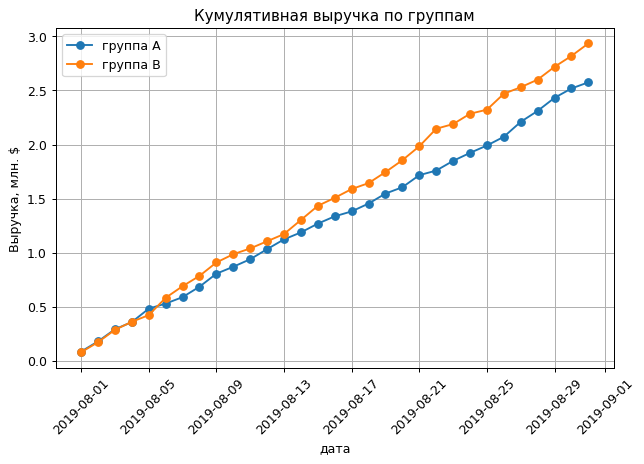

In [64]:
# Строим графики
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']*1.e-6, 'o-',label='группа A');
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']*1.e-6, 'o-',label='группа B');
plt.legend();

plt.title('Кумулятивная выручка по группам');
plt.xlabel('дата');
plt.ylabel('Выручка, млн. $');
plt.xticks(rotation=45);
plt.grid(True);


После "очистки" данных выручка группы В стабильно выше выручки грурры А. 

#### средний чек

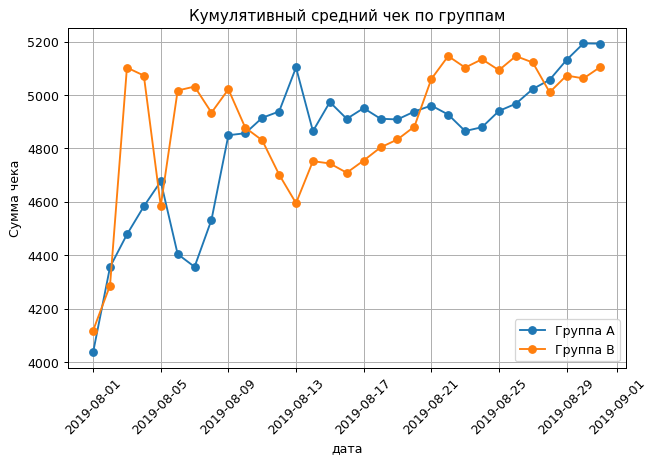

In [65]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], 'o-',label='Группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], 'o-',label='Группа B')
plt.legend(loc='lower right');

plt.title('Кумулятивный средний чек по группам');
plt.xlabel('дата');
plt.ylabel('Сумма чека');
plt.xticks(rotation=45);
plt.grid(True);

   
По очищенным данным наблюдается колебания среднего чека группы В вокруг значения  среднего чека группы А. В завершающей стадии явно проигрыш по сумме среднего чека.


Оценка вероятности ошибки и скоректированной ошибки по причине множествееной роверки гипотез

In [66]:
print('Вероятность ошибки {:.2%}, что больше 5%'.format(1 -(1 - 0.05) ** 2))

Вероятность ошибки 9.75%, что больше 5%


In [67]:
print('Вероятность ошибки {:.2%}, что гарантированно не более 5%'.format(1 -(1 - 0.05/2) ** 2))

Вероятность ошибки 4.94%, что гарантированно не более 5%


# Общий вывод
<a id="resume"></a>

Анализ результатов A/B теста показал, что 

* Замечания:
    * Удалены забросы по сумме чека и количеству покупок. Забросы искажают реальную картину
    
    
* Конверсия:
    * Конверсия по отфильтрованным данным и по "сырым" данным между выборками А и В численно отличается.
    * Конверсия выборки В относительно выборки А выглядит лучше, но определнной тенденции к увеличиению не наблюдается
    * Наблюдается статистически значимое различие конверсии между группами А и В. 
    * Цель фич из раздела 1 было увеличение конверсии и как следствие выручки. Цель достигнута - конверсия выросла, выручка также выросла.
    
    
* Средний чек: 
    * Средний чек группы В выше, но дальнейшая тенденция ближе к нисходящему тренду. 
    * Отсутствуют статистически значимые различия групп по среднему чеку как по "сырым" данным, так и по фильтрованным


* Выручка: 
    * Кумулятивная выручка группы В по очищенным данным стабильно выше выручки группы А



* Общий вывод:
    * После изучения среднего чека, конверсии, выручки по очищенным данным можно сделать вывод, что результат группы В лучше , чем группы А как по конверсии, так и по выручке, даже несмотря на то, что средний чек группы В несильно отличается от среднего чека группы А. Можно считать тест успешным и сказать, что цель увеличиения выручки достигнута